In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import pandas as pd
import csv

## Reading

In [2]:
plt.rcParams['figure.figsize'] = [8, 6]
plt.rcParams['figure.dpi'] = 150

In [3]:
row_start = 14

In [4]:
metadata = dict()
filename = "2.CSV"
with open(filename, newline='') as csvfile:
    reader = csv.reader(csvfile)
    for (i, row) in enumerate(reader):
        if i > row_start: break
        if len(row) >= 2: metadata[row[0]] = row[1]
metadata

FileNotFoundError: [Errno 2] No such file or directory: 'T0014ALL.CSV'

In [5]:
data = pd.read_csv(filename, delimiter=",", header=row_start)
data

,TIME,CH1,CH1 Peak Detect,Unnamed: 3,TIME.1,MATH,Unnamed: 6,TIME.2,REF1,REF1 Peak Detect
0,-10.0000,-8.1,-7.9,NaN,0.000000e+00,17.30310,NaN,-10.0000,-2.384190e-09,-1.620000e+00
1,-9.9998,-7.9,-8.3,NaN,2.000000e-08,15.74690,NaN,-9.9998,-1.620000e+00,-1.620000e+00
2,-9.9997,-7.9,-7.9,NaN,4.000000e-08,14.19060,NaN,-9.9997,-1.620000e+00,4.000000e-02
3,-9.9995,-7.9,-8.3,NaN,6.000000e-08,-6.11875,NaN,-9.9995,-1.620000e+00,-1.620000e+00
4,-9.9994,-8.1,-7.7,NaN,8.000000e-08,-26.42810,NaN,-9.9994,-1.620000e+00,-1.620000e+00
...,...,...,...,...,...,...,...,...,...,...
124995,9.9992,-5.7,-5.9,NaN,NaN,NaN,NaN,9.9992,4.000000e-02,-2.384190e-09
124996,9.9994,-5.7,-5.5,NaN,NaN,NaN,NaN,9.9994,4.000000e-02,8.000000e-02
124997,9.9995,-5.7,-6.1,NaN,NaN,NaN,NaN,9.9995,6.000000e-02,-2.384190e-09
124998,9.9997,-5.7,-5.5,NaN,NaN,NaN,NaN,9.9997,4.000000e-02,8.000000e-02


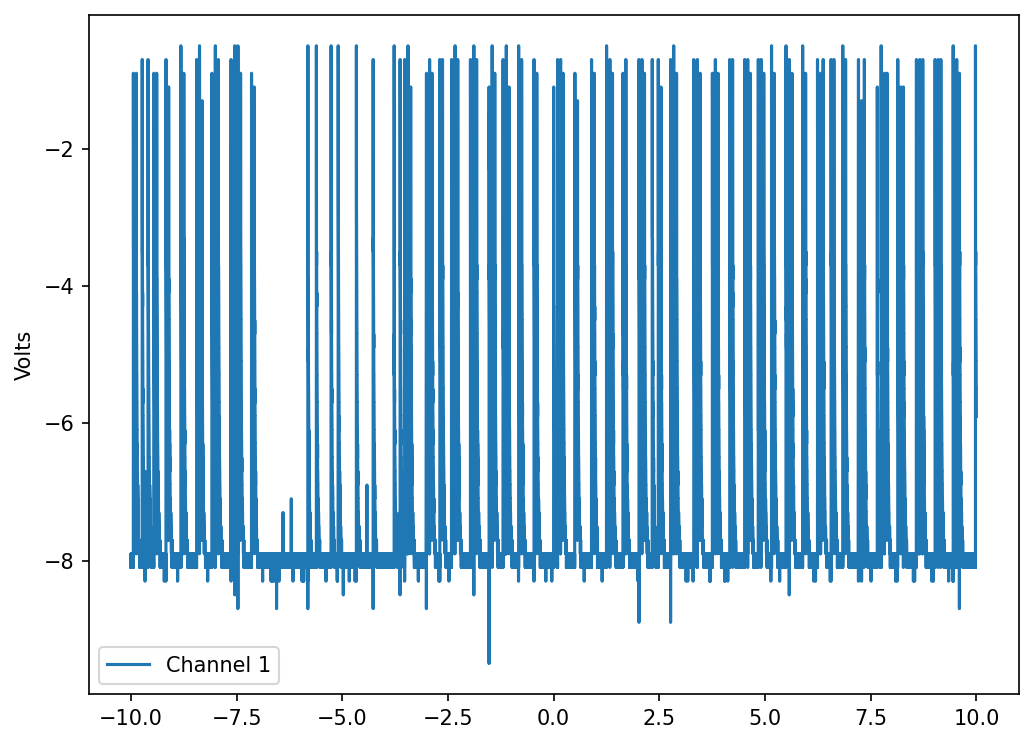

In [6]:
t_raw = data["TIME"].to_numpy()
ch1_raw = data["CH1"].to_numpy()
plt.plot(
    t_raw, 
    ch1_raw,
    label="Channel 1"
)
plt.ylabel("Volts")
plt.legend()

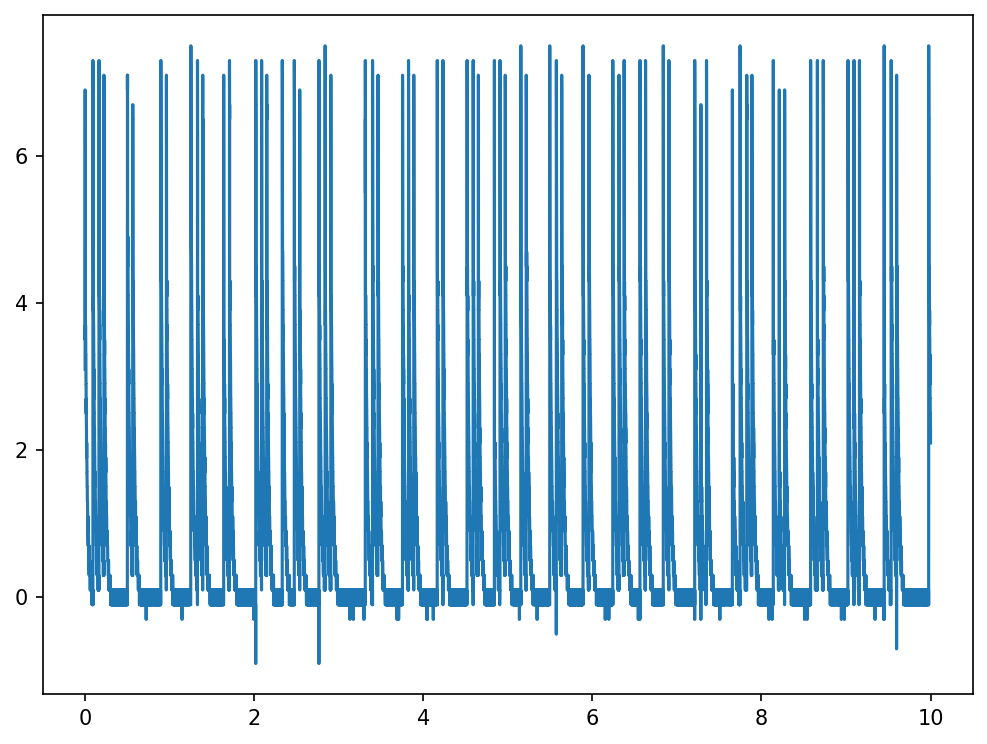

In [16]:
ch1 = ch1_raw[t_raw>0] + 8
t = t_raw[t_raw>0]
plt.plot(t, ch1)
plt.show()

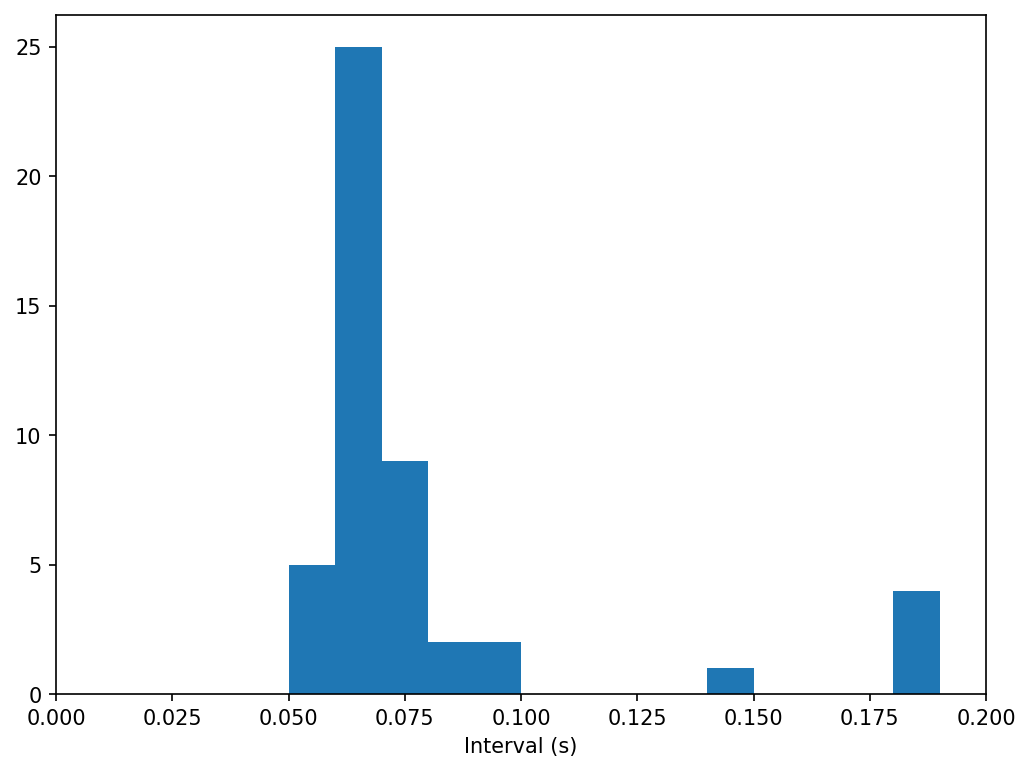

In [32]:
intervals = np.diff(t[ch1 > 6])
intervals = intervals[intervals > 0.01]
plt.hist(intervals, bins=20, range=(0,0.2))
plt.xlim(0,0.2)
plt.xlabel("Interval (s)")
plt.show()

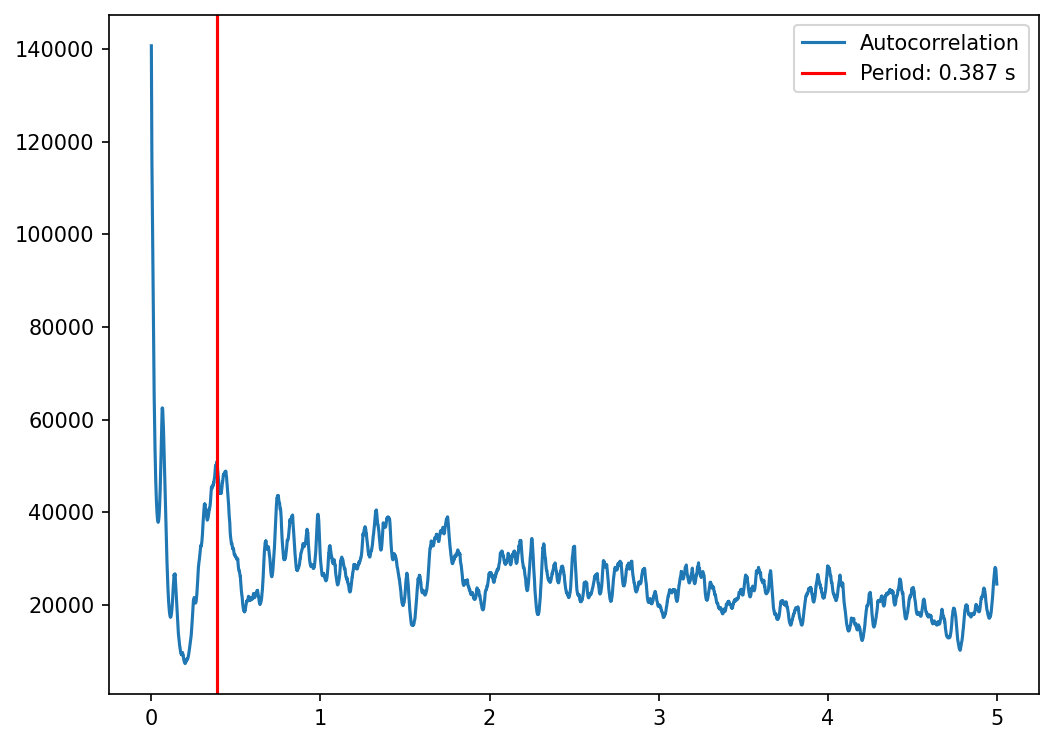

In [90]:
auto = sp.signal.correlate(ch1, ch1, mode="same")
auto = auto[auto.size//2:]

plt.plot(
    t[:auto.size],
    auto,
    label="Autocorrelation"
)
# plt.xlim(5,6)
period = t[t > 0.1][np.argmax(auto[t[:auto.size] > 0.1])]
plt.axvline(period, color="red", label=f"Period: {period:.3f} s")
plt.legend()

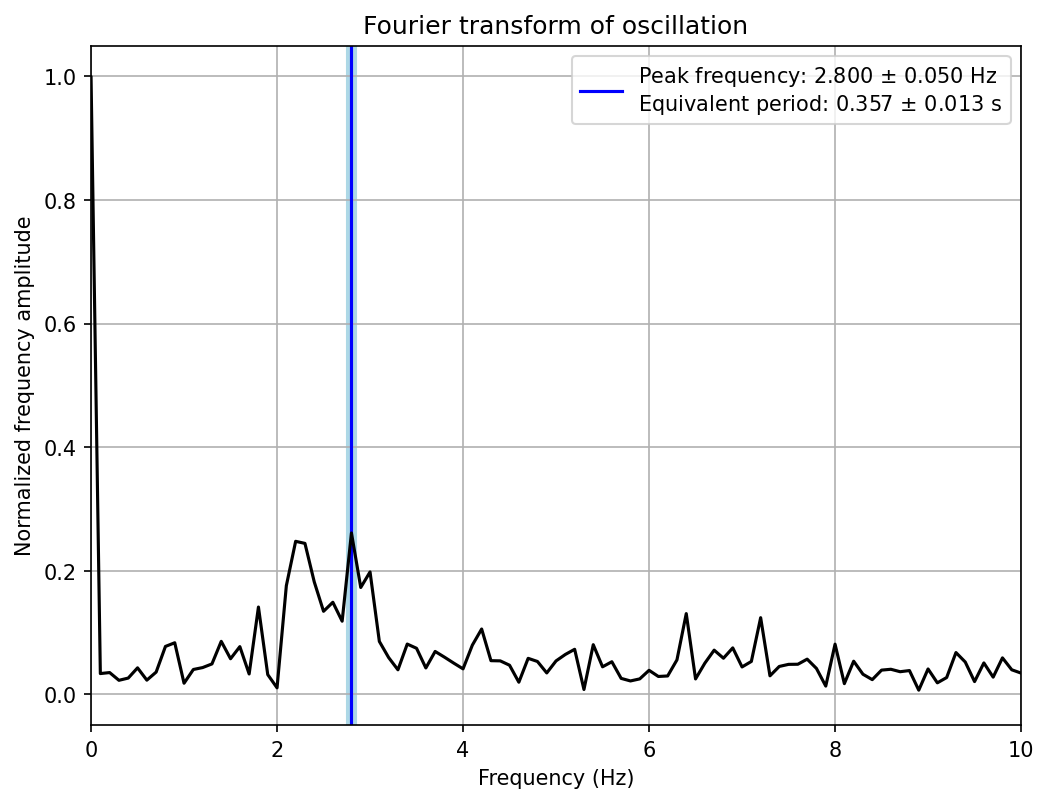

In [89]:
from scipy.fft import fft, fftfreq, fftshift

spectrum = np.abs(fftshift(fft(ch1)))
spectrum /= np.max(spectrum)
sampling_rate = 1 / np.average(np.diff(t))
freq = fftshift(fftfreq(t.size, 1/sampling_rate))
bin_width = np.average(np.diff(freq))

maxfreq = freq[freq > 1][np.argmax(spectrum[freq > 1])]
leftfreq = maxfreq - bin_width/2
rightfreq = maxfreq + bin_width/2
plt.axvline(maxfreq, color="blue", 
            label=f"""Peak frequency: {maxfreq:.3f} $\pm$ {bin_width/2:.3f} Hz
Equivalent period: {1/maxfreq:.3f} $\pm$ {1/leftfreq - 1/rightfreq:.3f} s""")
plt.axvspan(
    leftfreq, 
    rightfreq, 
    color="lightblue")

plt.title("Fourier transform of oscillation")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Normalized frequency amplitude")
plt.xlim(0, 10)
# plt.ylim(0, 1.1)
plt.plot(freq, spectrum, color="black")
plt.grid()
plt.legend()
plt.show()

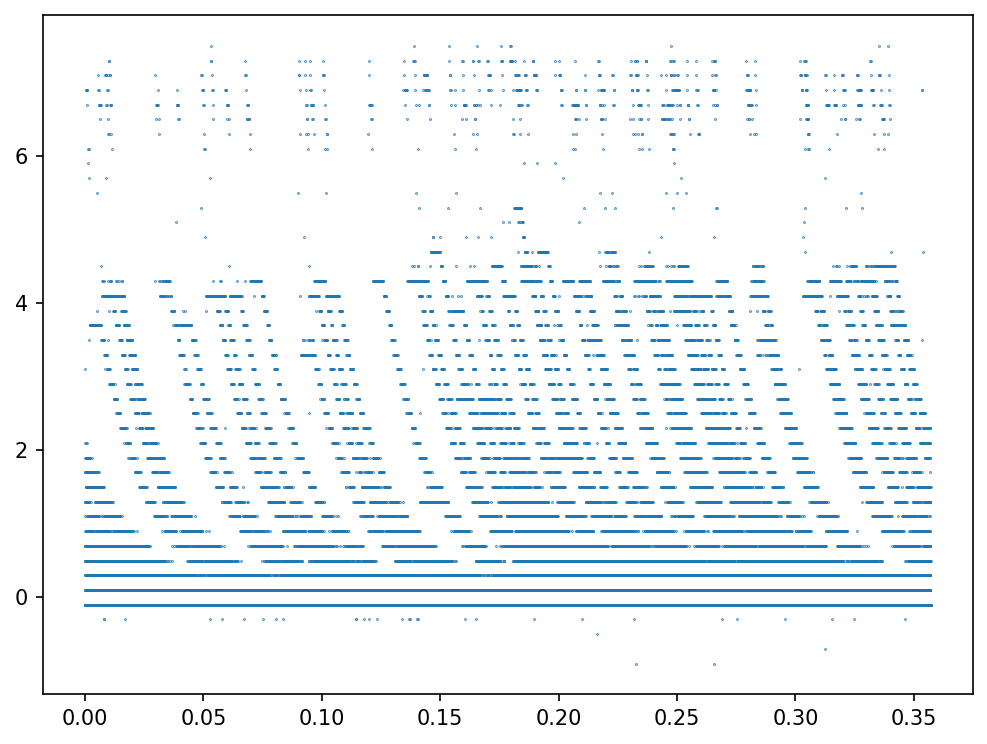

In [93]:
plt.scatter(t % (1 / maxfreq), ch1, s=0.1)